# Scenario 3
For scenario 3, from the description: "Explore the space of closely related models (structurally speaking) that incorporate either deaths, hospitalizations, or both.". For this purpose, models 958 and 960 are relevant.

In [1]:
from mira.modeling import Model
from mira.modeling.petri import PetriNetModel
from mira.sources.biomodels import get_template_model
from mira.metamodel import TemplateModelDelta, ControlledConversion
from mira.dkg.web_client import is_ontological_child_web
from mira.metamodel.ops import simplify_rate_laws

In [2]:
# Get models 958 and 960
model_958 = simplify_rate_laws(get_template_model("BIOMD0000000958"))
model_960 = simplify_rate_laws(get_template_model("BIOMD0000000960"))

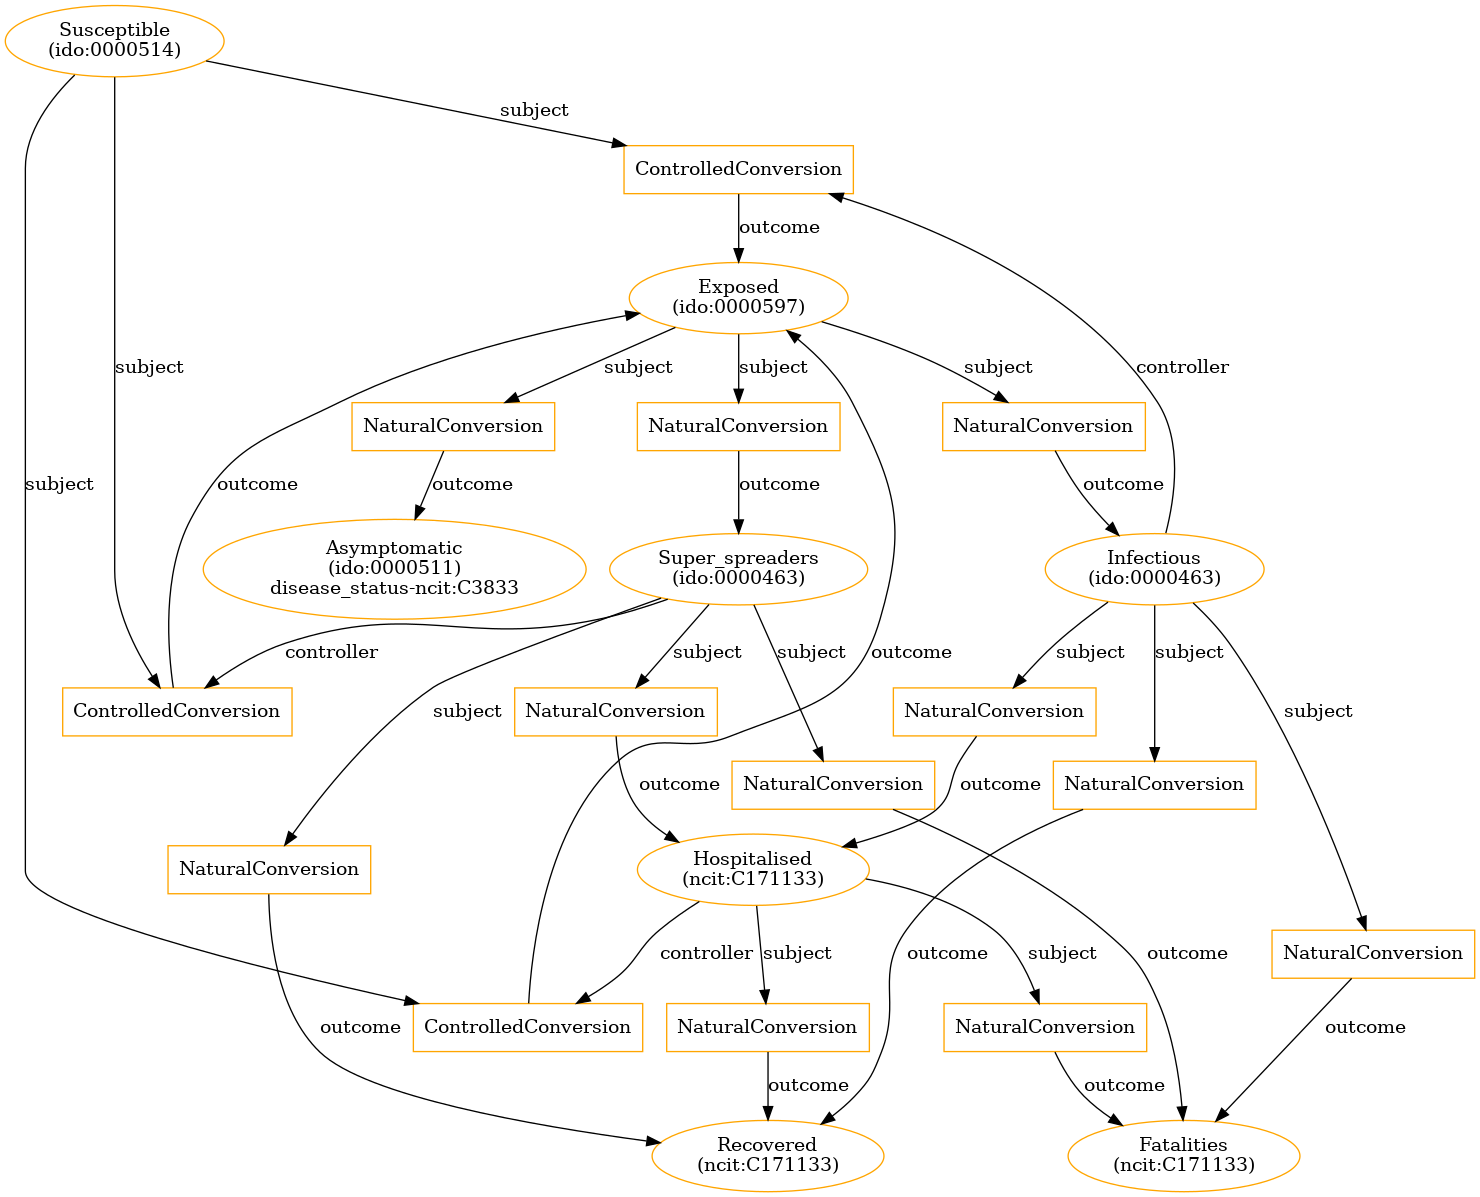

In [3]:
# Check out the models
from IPython.display import Image
model_958.draw_graph("scenario3_model_958.png")
Image(filename="scenario3_model_958.png", width='50%')

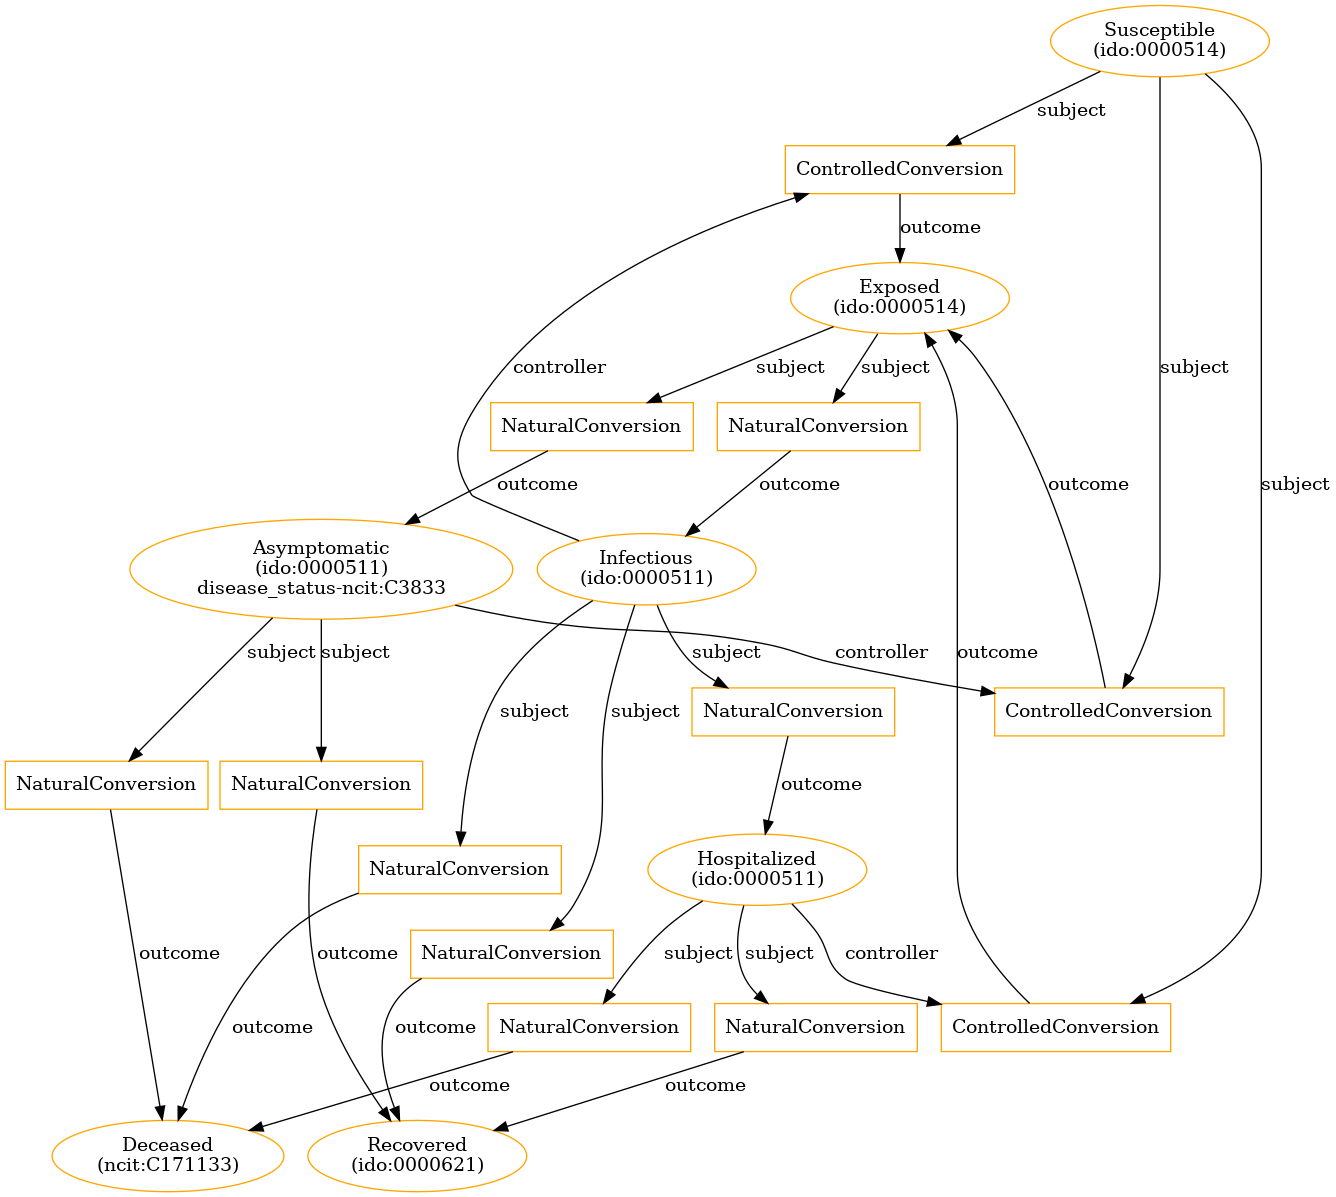

In [4]:
model_960.draw_graph("scenario3_model_960.png")
Image(filename="scenario3_model_960.png", width='50%')

## Human in the loop improvements
As can be seen in the output above, several concepts have vague identification and need to be better annotated in order to disambiguate them. The human in the loop intervention needed is "simulated" by the following mapping:

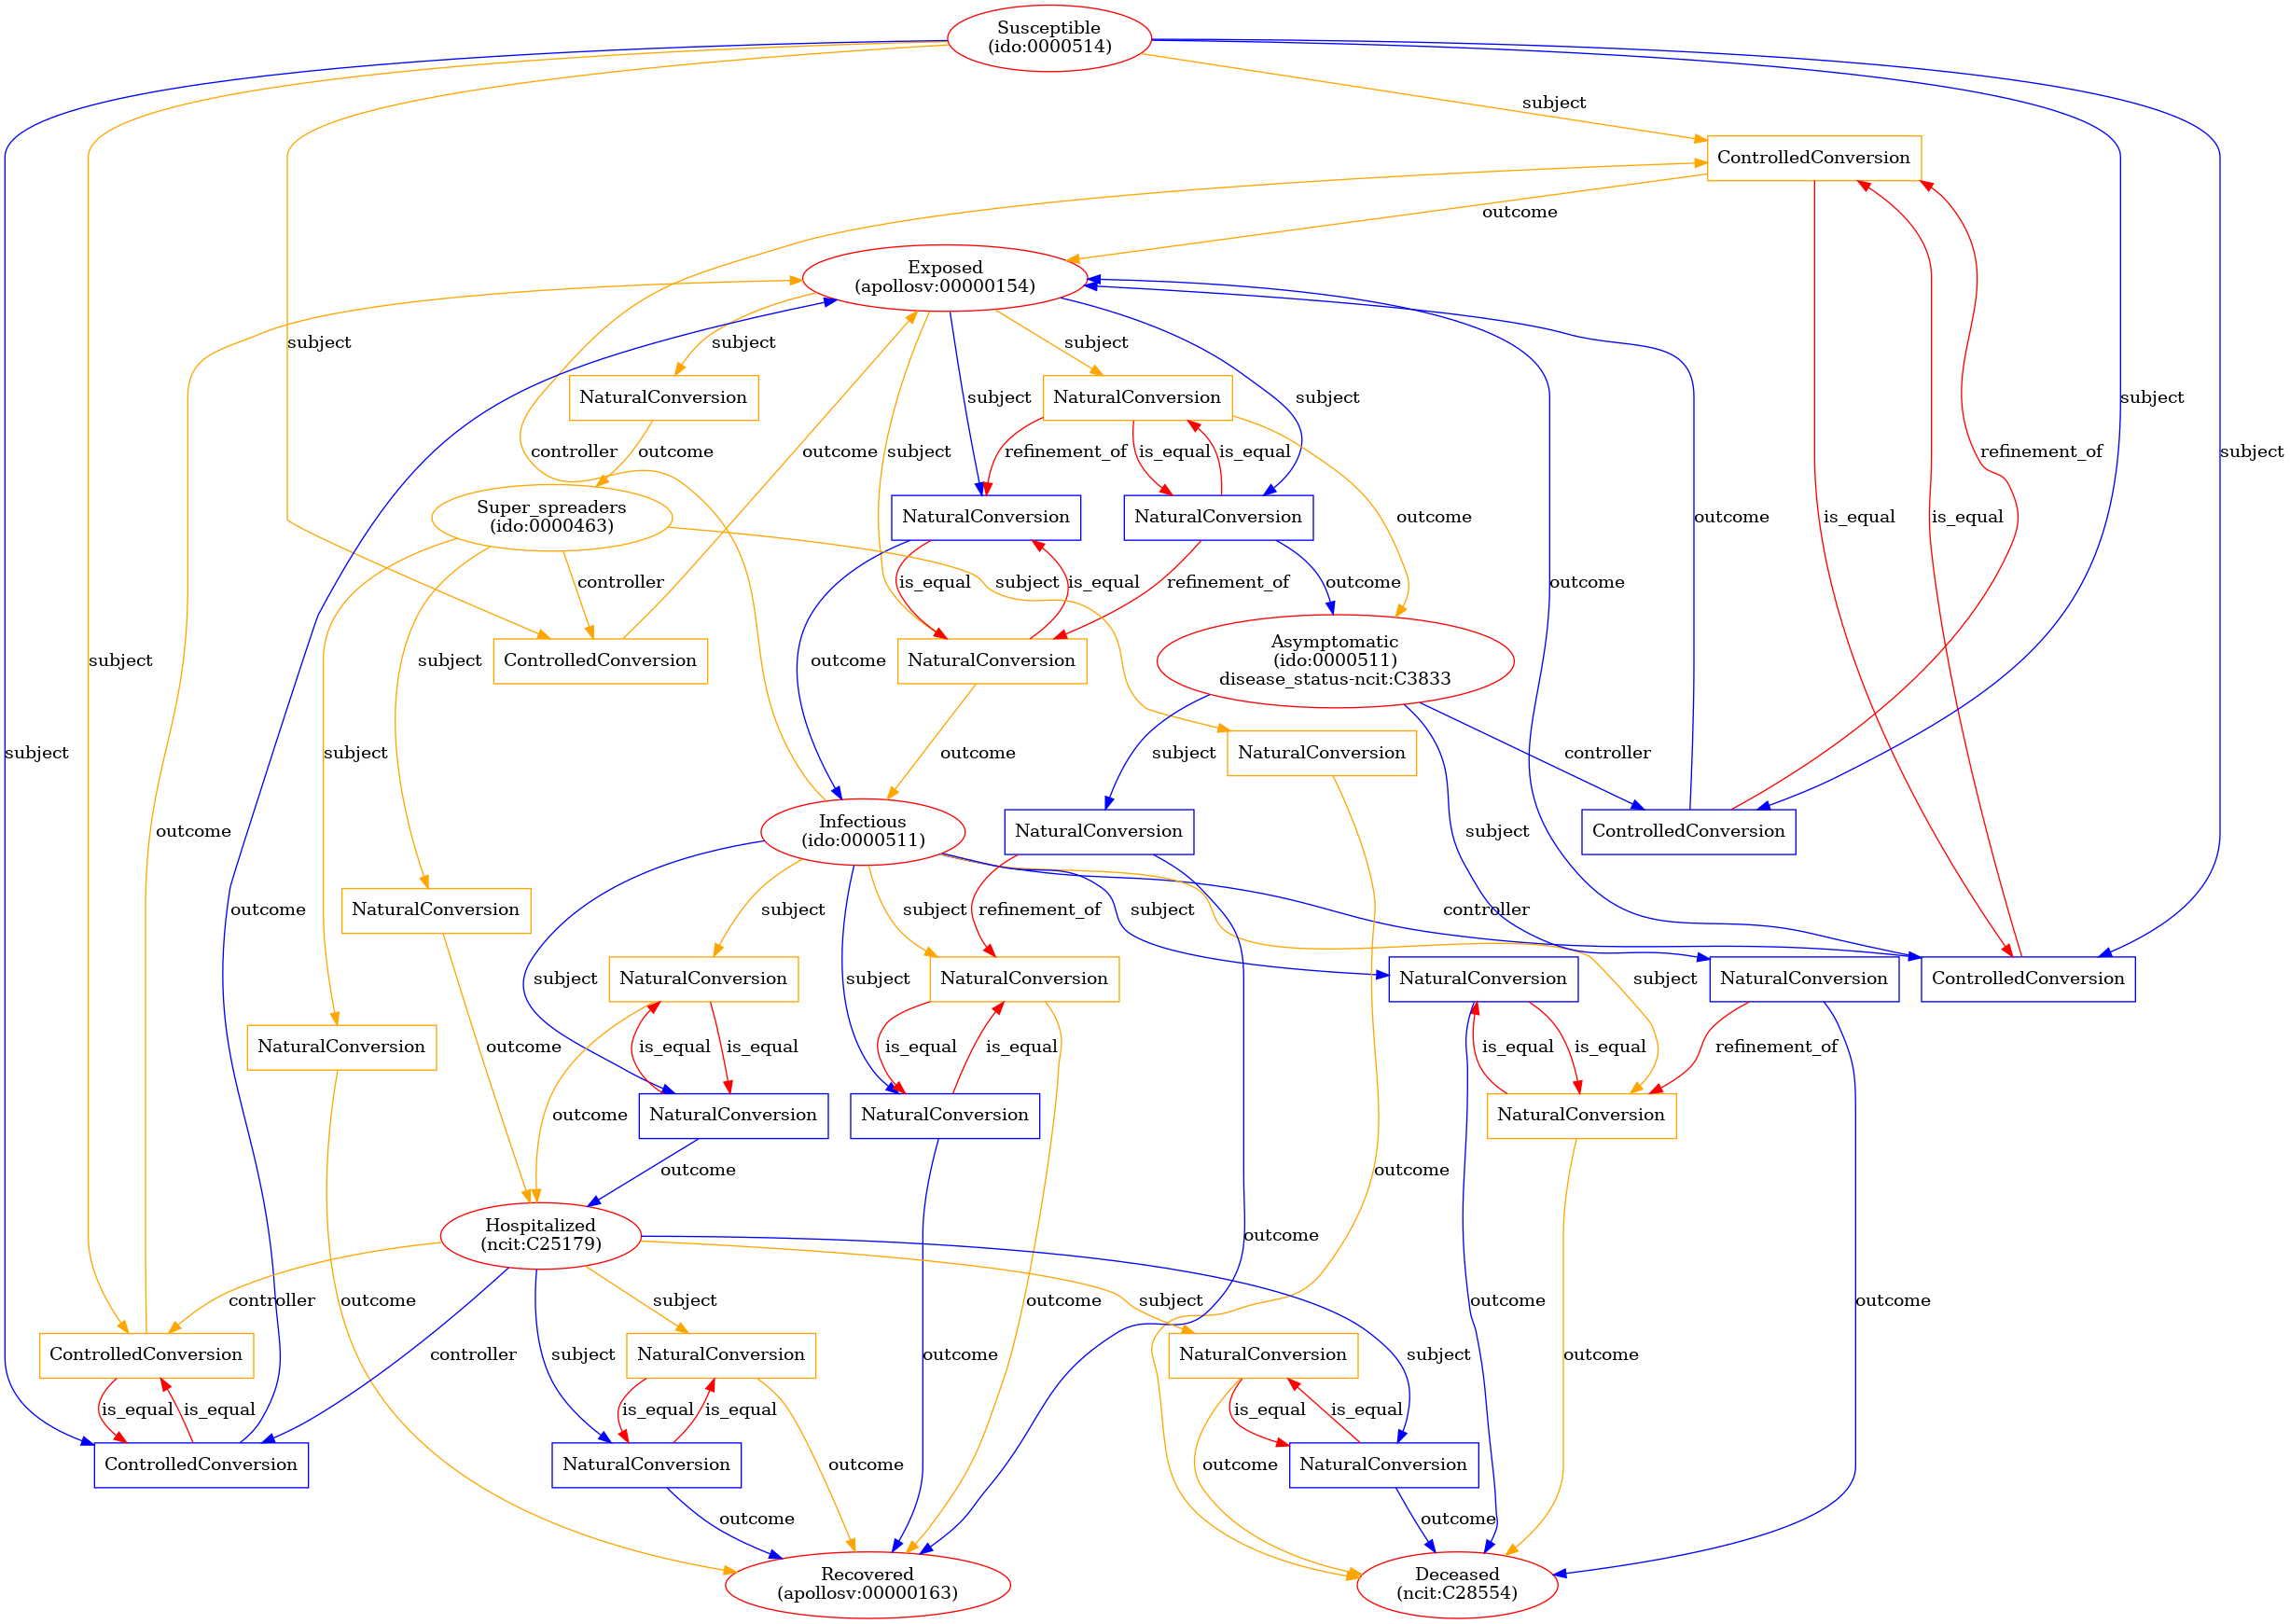

In [5]:
from mira.metamodel import Concept

# Identifiers seen here:
# ncit:C171133 (covid-19 infection) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C171133
# ncit:C28554 (death) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C28554
# ncit:C25179 (hospitalization) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C25179
# apollosv:00000163 (Recoverd Population) https://ontobee.org/ontology/APOLLO_SV?iri=http://purl.obolibrary.org/obo/APOLLO_SV_00000163
# ido:0000511 (infected population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000511
# ido:0000514 (susceptible population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000514

concept_mapping = {
    "958": {
        "Exposed": Concept(name="Exposed",
                           identifiers={"apollosv": "00000154"}),
        "Infectious": Concept(name="Infectious",
                              identifiers={"ido": "0000511", "apollosv": "00000163"}),
        "Fatalities": Concept(name="Fatalities",
                              identifiers={"ncit": "C28554"}),
        "Hospitalised": Concept(name="Hospitalised",
                                identifiers={"ncit": "C25179"}),
        "Recovered": Concept(name="Recovered",
                             identifiers={"apollosv": "00000163"}),
    },
    "960": {
        "Exposed": Concept(name="Exposed",
                           identifiers={"apollosv": "00000154"}),
        "Deceased": Concept(name="Deceased",
                            identifiers={"ncit": "C28554"}),
        "Infectious": Concept(name="Infectious",
                              identifiers={"ido": "0000511", "apollosv": "00000163"}),
        "Hospitalized": Concept(name="Hospitalized",
                                identifiers={"ncit": "C25179"}),
        "Recovered": Concept(name="Recovered",
                             identifiers={"apollosv": "00000163"}),
    }
}

# Map the concepts from previous
for template_958 in model_958.templates:
    for concept in template_958.get_concepts():
        if concept.name in concept_mapping["958"]:
            concept.identifiers = concept_mapping["958"][concept.name].identifiers

for template_960 in model_960.templates:
    for concept in template_960.get_concepts():
        if concept.name in concept_mapping["960"]:
            concept.identifiers = concept_mapping["960"][concept.name].identifiers

# Now do the comparison
tmd_corr = TemplateModelDelta(model_958, model_960, refinement_function=is_ontological_child_web)
tmd_corr.draw_graph("scenario3_model_958_960_delta_corrected.png", args="-Grankdir=TB")
Image(filename="scenario3_model_958_960_delta_corrected.png")

In [6]:
petri_958 = PetriNetModel(Model(model_958))
petri_960 = PetriNetModel(Model(model_960))
for mname, model in [("scenario3_biomd958.json", petri_958), ("scenario3_biomd960.json", petri_960)]:
    model.to_json_file(mname, indent=1)
# Also dump the mira model jsons
with open("scenario3_biomd958_mira.json", "w") as f:
    f.write(model_958.json(indent=1))
with open("scenario3_biomd960_mira.json", "w") as f:
    f.write(model_960.json(indent=1))

In [7]:
# Simplify rate laws and make new Petri net model
from mira.metamodel.ops import simplify_rate_laws, aggregate_parameters
for mname, model in [("scenario3_biomd958_rate_law_subs.json", model_958),
                     ("scenario3_biomd960_rate_law_subs.json", model_960)]:
    model2 = aggregate_parameters(simplify_rate_laws(model))
    pm = PetriNetModel(Model(model2))
    pm.to_json_file(mname, indent=1)

## Add vaccination
We now need to add vaccination to the two models

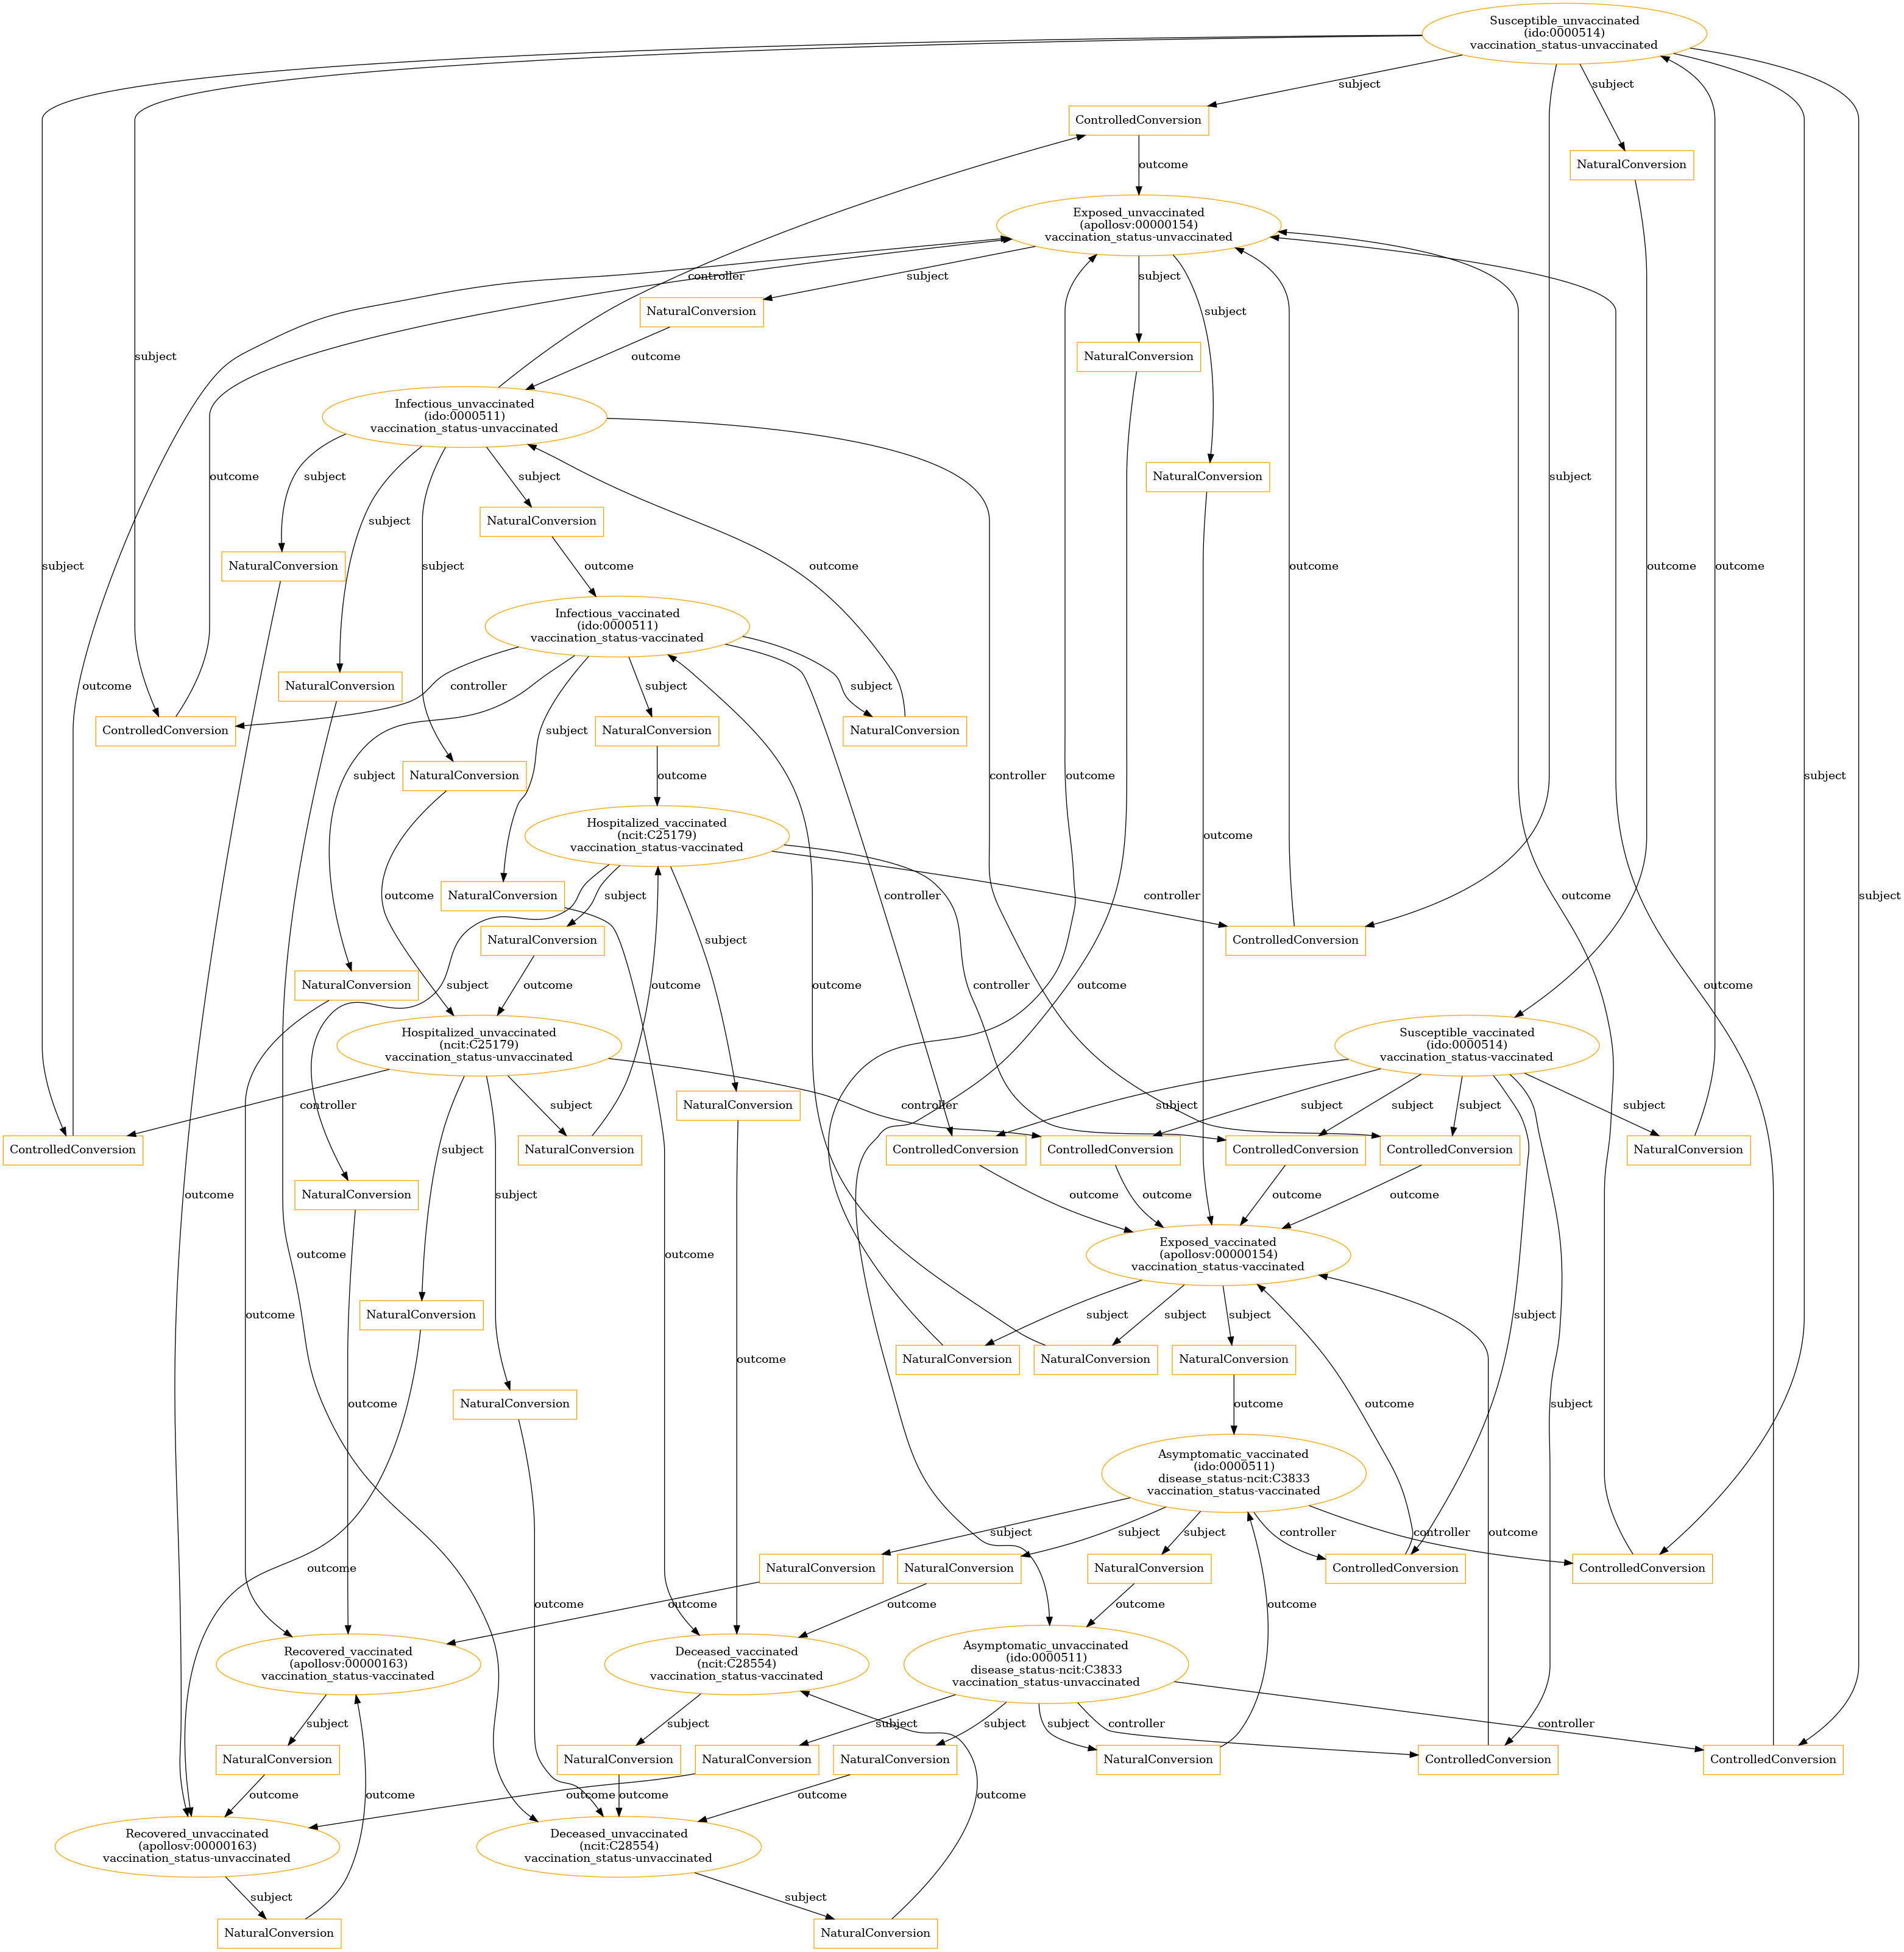

In [8]:
from mira.metamodel.ops import stratify

model_958_vaccination = stratify(model_958, key="vaccination_status", strata={"vaccinated", "unvaccinated"}, directed=False, cartesian_control=True, modify_names=True)
model_958_vaccination.draw_graph("scenario3_model_958_vaccination.png")
Image(filename="scenario3_model_958_vaccination.png")
model_960_vaccination = stratify(model_960, key="vaccination_status", strata={"vaccinated", "unvaccinated"}, directed=False, cartesian_control=True, modify_names=True)
model_960_vaccination.draw_graph("scenario3_model_960_vaccination.png")
Image(filename="scenario3_model_960_vaccination.png")

## Add reinfection
We're asked to add reinfection to the model. This is done by adding one transition per each infectious node using ControlledConversion with `recovered` as subject, `exposed` as outcome and the infectious node as controller. We start with the corrected models, add reinfection and then stratify them based on vaccination status.

In [9]:
# Get the recovered and infected nodes from each model
node_names_958 = ("Exposed", "Super_spreaders", "Asymptomatic", "Recovered", "Infectious")
concepts_958 = {}
for template in model_958.templates:
    for concept in template.get_concepts():
        if concept.name in node_names_958 and concept.name not in concepts_958:
            concepts_958[concept.name] = concept

for name, concept in concepts_958.items():
    print(f"{name}:",concept.name, concept.identifiers)

Infectious: Infectious {'ido': '0000511', 'apollosv': '00000163'}
Exposed: Exposed {'apollosv': '00000154'}
Super_spreaders: Super_spreaders {'ncit': '0000511', 'ido': '0000463'}
Asymptomatic: Asymptomatic {'ncit': 'C171133', 'ido': '0000511'}
Recovered: Recovered {'apollosv': '00000163'}


In [10]:
exposed_958 = concepts_958["Exposed"]
superspreaders_958 = concepts_958["Super_spreaders"]
asymptomatic_958 = concepts_958["Asymptomatic"]
recovered_958 = concepts_958["Recovered"]
infected_958 = concepts_958["Infectious"]

# Create the transitions, add the rate laws (for all transitions), and add them to the models. Add one ControlledConversion per vaccination status per infectious node.

# 1. Reinfection by infectious
reinfection_958_infectious = ControlledConversion(
    subject=recovered_958,
    controller=infected_958,
    outcome=exposed_958)
reinfection_958_infectious.set_mass_action_rate_law("reinfection_rate_infectious")

# 2. Reinfection by superspreaders
reinfection_958_superspreaders = ControlledConversion(
    subject=recovered_958,
    controller=superspreaders_958,
    outcome=exposed_958)
reinfection_958_superspreaders.set_mass_action_rate_law("reinfection_rate_superspreaders")

# 3. Reinfection by asymptomatic
reinfection_958_asymptomatic = ControlledConversion(
    subject=recovered_958,
    controller=asymptomatic_958,
    outcome=exposed_958)
reinfection_958_asymptomatic.set_mass_action_rate_law("reinfection_rate_asymptomatic")

from mira.metamodel import Parameter, TemplateModel

# Extend model 958
model_958_reinfection = model_958.extend(
    template_model=TemplateModel(
        templates=[reinfection_958_infectious, reinfection_958_superspreaders, reinfection_958_asymptomatic],
        parameters={
            "reinfection_rate_infectious": Parameter(name="reinfection_rate_infectious", value=1),
            "reinfection_rate_superspreaders": Parameter(name="reinfection_rate_superspreaders", value=1),
            "reinfection_rate_asymptomatic": Parameter(name="reinfection_rate_asymptomatic", value=1)
        },
    )
)

# Get Exposed, Infectious, Asymptomatic, and Recovered nodes from model 960
node_names_960 = ("Exposed", "Asymptomatic", "Recovered", "Infectious")
concepts_960 = {}
for template in model_960.templates:
    for concept in template.get_concepts():
        if concept.name in node_names_960 and concept.name not in concepts_960:
            concepts_960[concept.name] = concept

for name, concept in concepts_960.items():
    print(f"{name}:",concept.name, concept.identifiers)

Infectious: Infectious {'ido': '0000511', 'apollosv': '00000163'}
Exposed: Exposed {'apollosv': '00000154'}
Asymptomatic: Asymptomatic {'ncit': 'C171133', 'ido': '0000511'}
Recovered: Recovered {'apollosv': '00000163'}


In [11]:
asymptomatic_960 = concepts_960["Asymptomatic"]
exposed_960 = concepts_960["Exposed"]
recovered_960 = concepts_960["Recovered"]
infected_960 = concepts_960["Infectious"]

# Create the transitions, add the rate laws (for all transitions), and add them to the models
# Reinfection by infectious
reinfection_960_infectious = ControlledConversion(
    subject=recovered_960,
    controller=infected_960,
    outcome=exposed_960)
reinfection_960_infectious.set_mass_action_rate_law("reinfection_rate_infectious")

# Reinfection by asymptomatic
reinfection_960_asymptomatic = ControlledConversion(
    subject=recovered_960,
    controller=asymptomatic_960,
    outcome=exposed_960)
reinfection_960_asymptomatic.set_mass_action_rate_law("reinfection_rate_asymptomatic")

# Extend model 960
model_960_reinfection = model_960.extend(
    template_model=TemplateModel(
        templates=[reinfection_960_infectious, reinfection_960_asymptomatic],
        parameters={
            "reinfection_rate_infectious": Parameter(name="reinfection_rate_infectious", value=1),
            "reinfection_rate_asymptomatic": Parameter(name="reinfection_rate_asymptomatic", value=1)
        },
    )
)

In [12]:
# Stratify the models by vaccination status
model_958_vaccination_reinfection = stratify(
    model_958_reinfection,
    key="vaccination_status",
    strata=["vaccinated", "unvaccinated"],
    directed=True,
    cartesian_control=True,
    modify_names=True
)
from mira.metamodel import NaturalConversion

# Prune vaccination transitions: Fatalities_unvaccinated -> Fatalities_vaccinated
model_ix = None
death_vaccination_transition = None
for ix, template in enumerate(model_958_vaccination_reinfection.templates):
    if isinstance(template, NaturalConversion):
        if template.subject.name == "Fatalities_unvaccinated" and template.outcome.name == "Fatalities_vaccinated":
            model_ix = ix
            death_vaccination_transition = template
            break
assert model_ix is not None
assert death_vaccination_transition is not None
# Remove the template
model_958_vaccination_reinfection.templates.pop(model_ix)

# Check if there is a corresponding rate law parameter from the model
if death_vaccination_transition.rate_law is not None:
    for key, param in model_958_vaccination_reinfection.parameters.items():
        print(key, "-:-", param)
else:
    print("No rate law parameter found")

No rate law parameter found


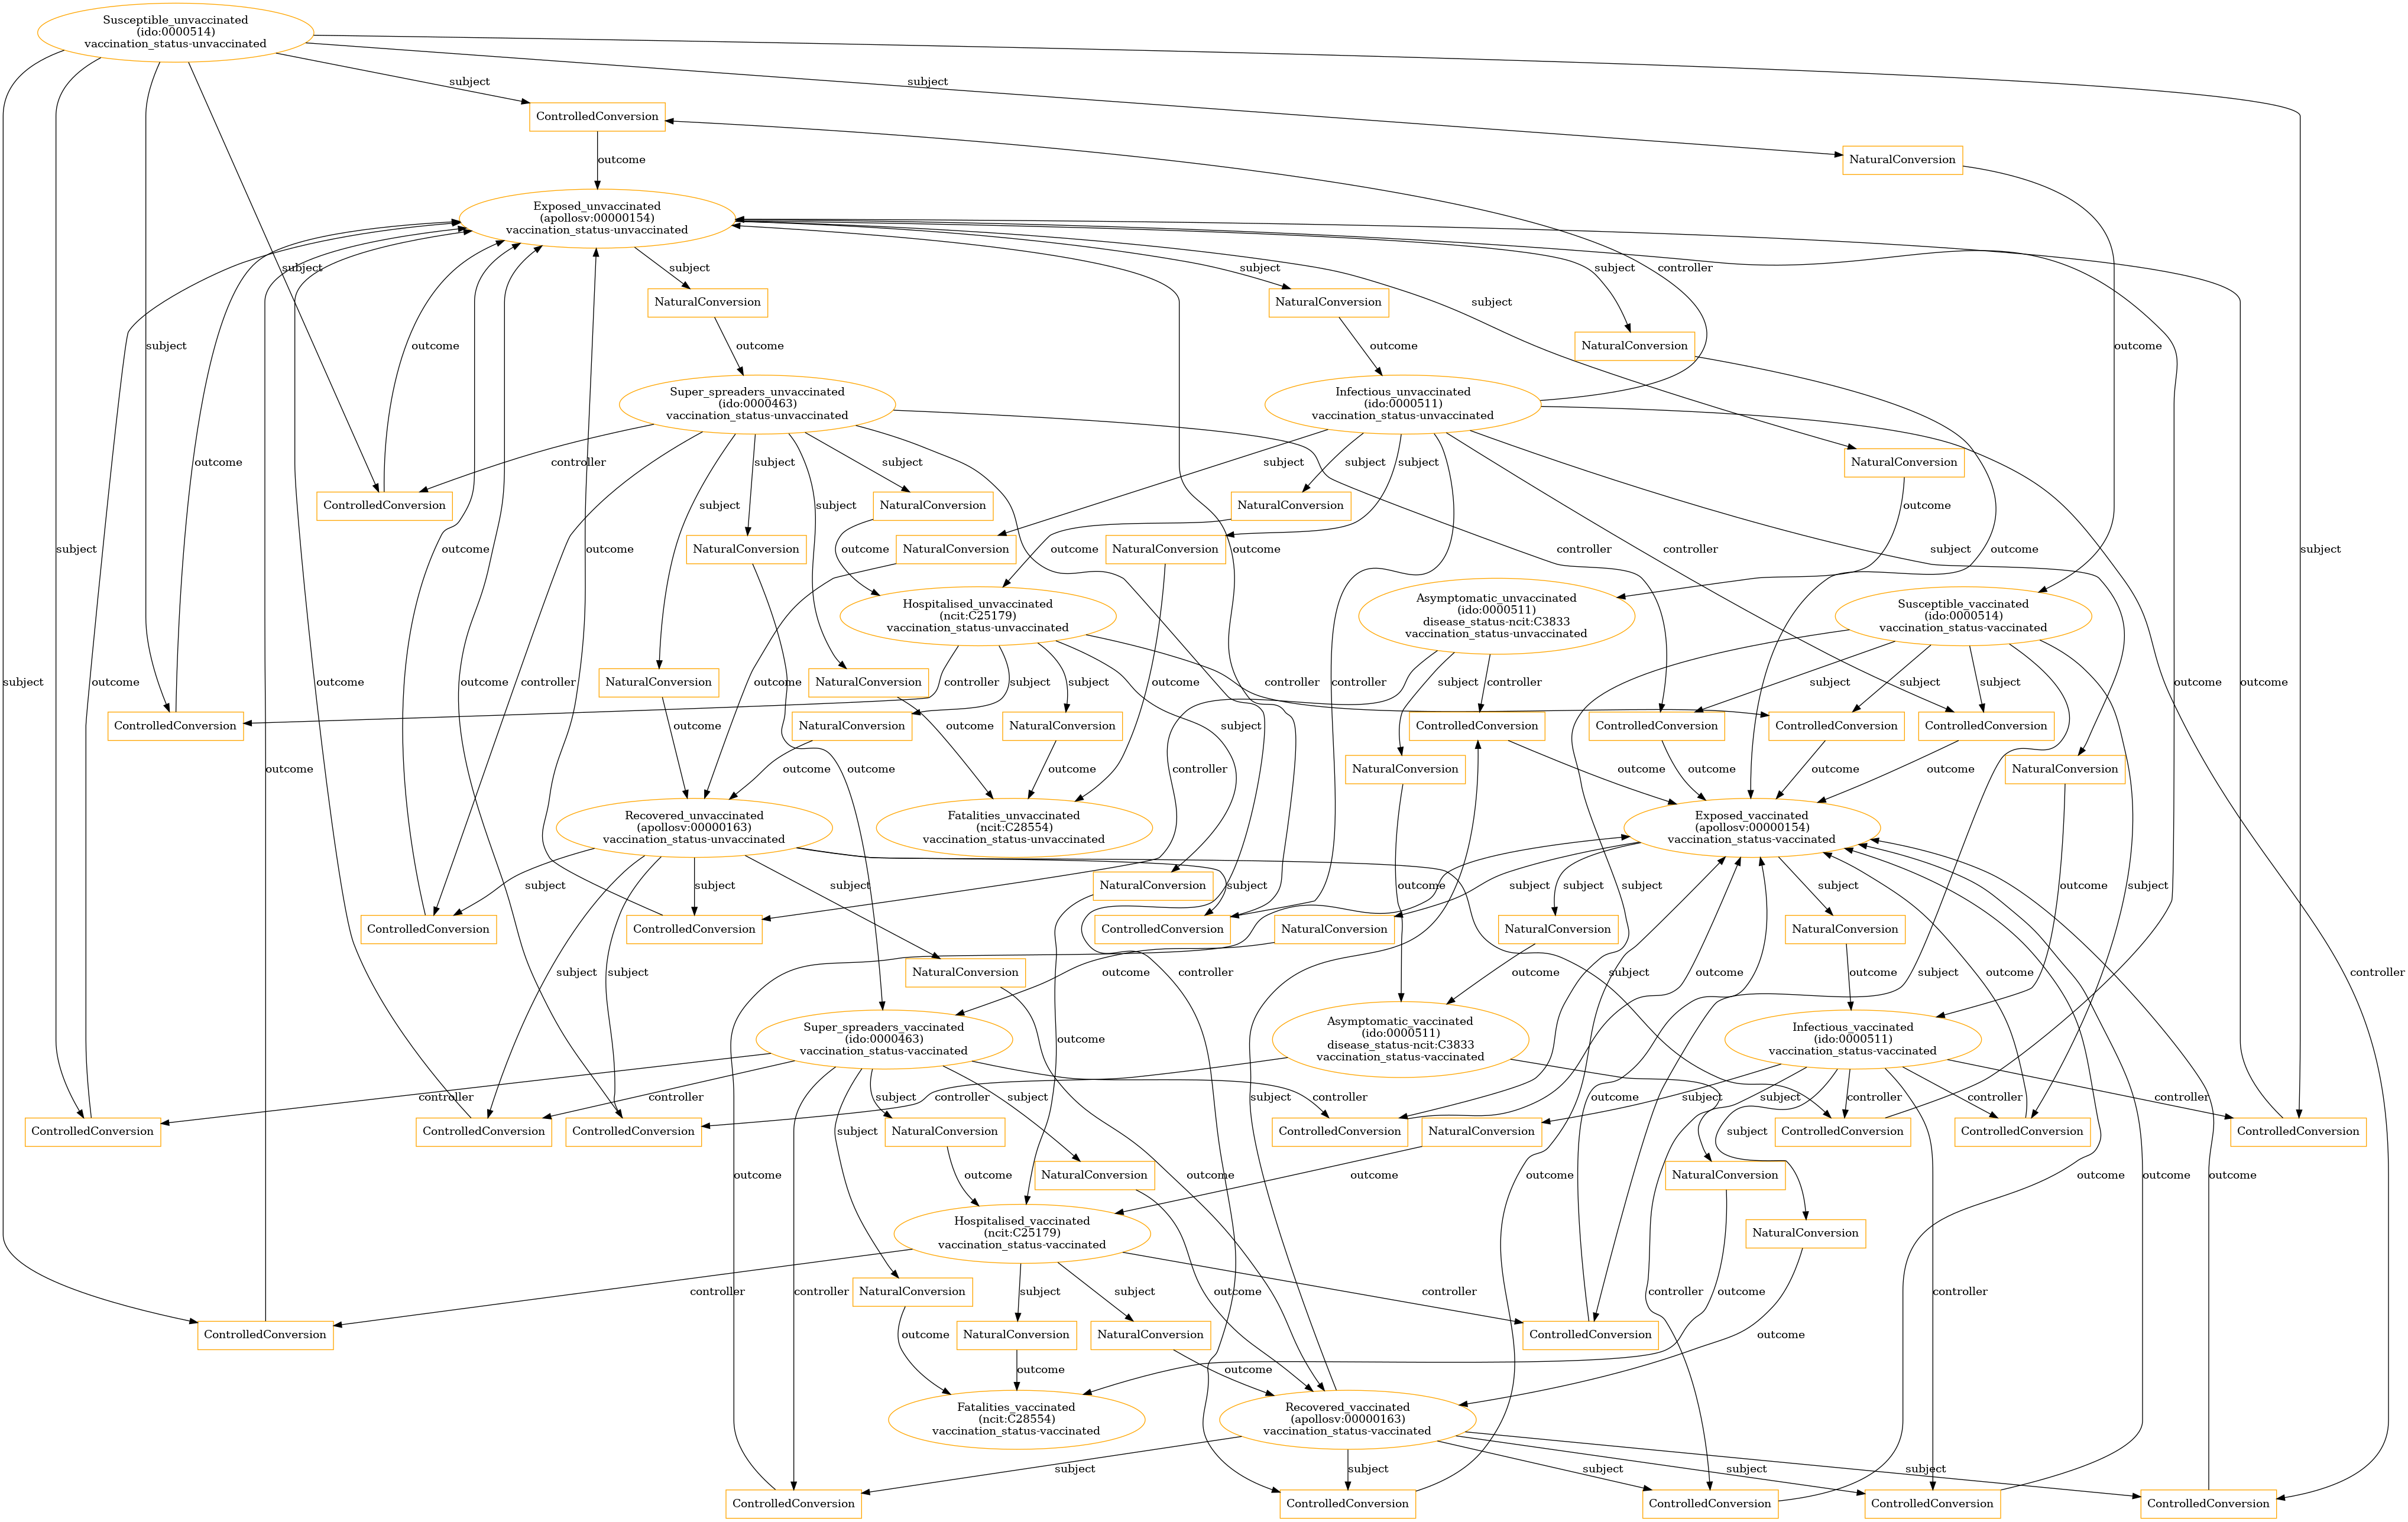

In [13]:
# Check out the model
model_958_vaccination_reinfection.draw_graph("scenario3_model_958_vaccination_reinfection.png")
Image(filename="scenario3_model_958_vaccination_reinfection.png")

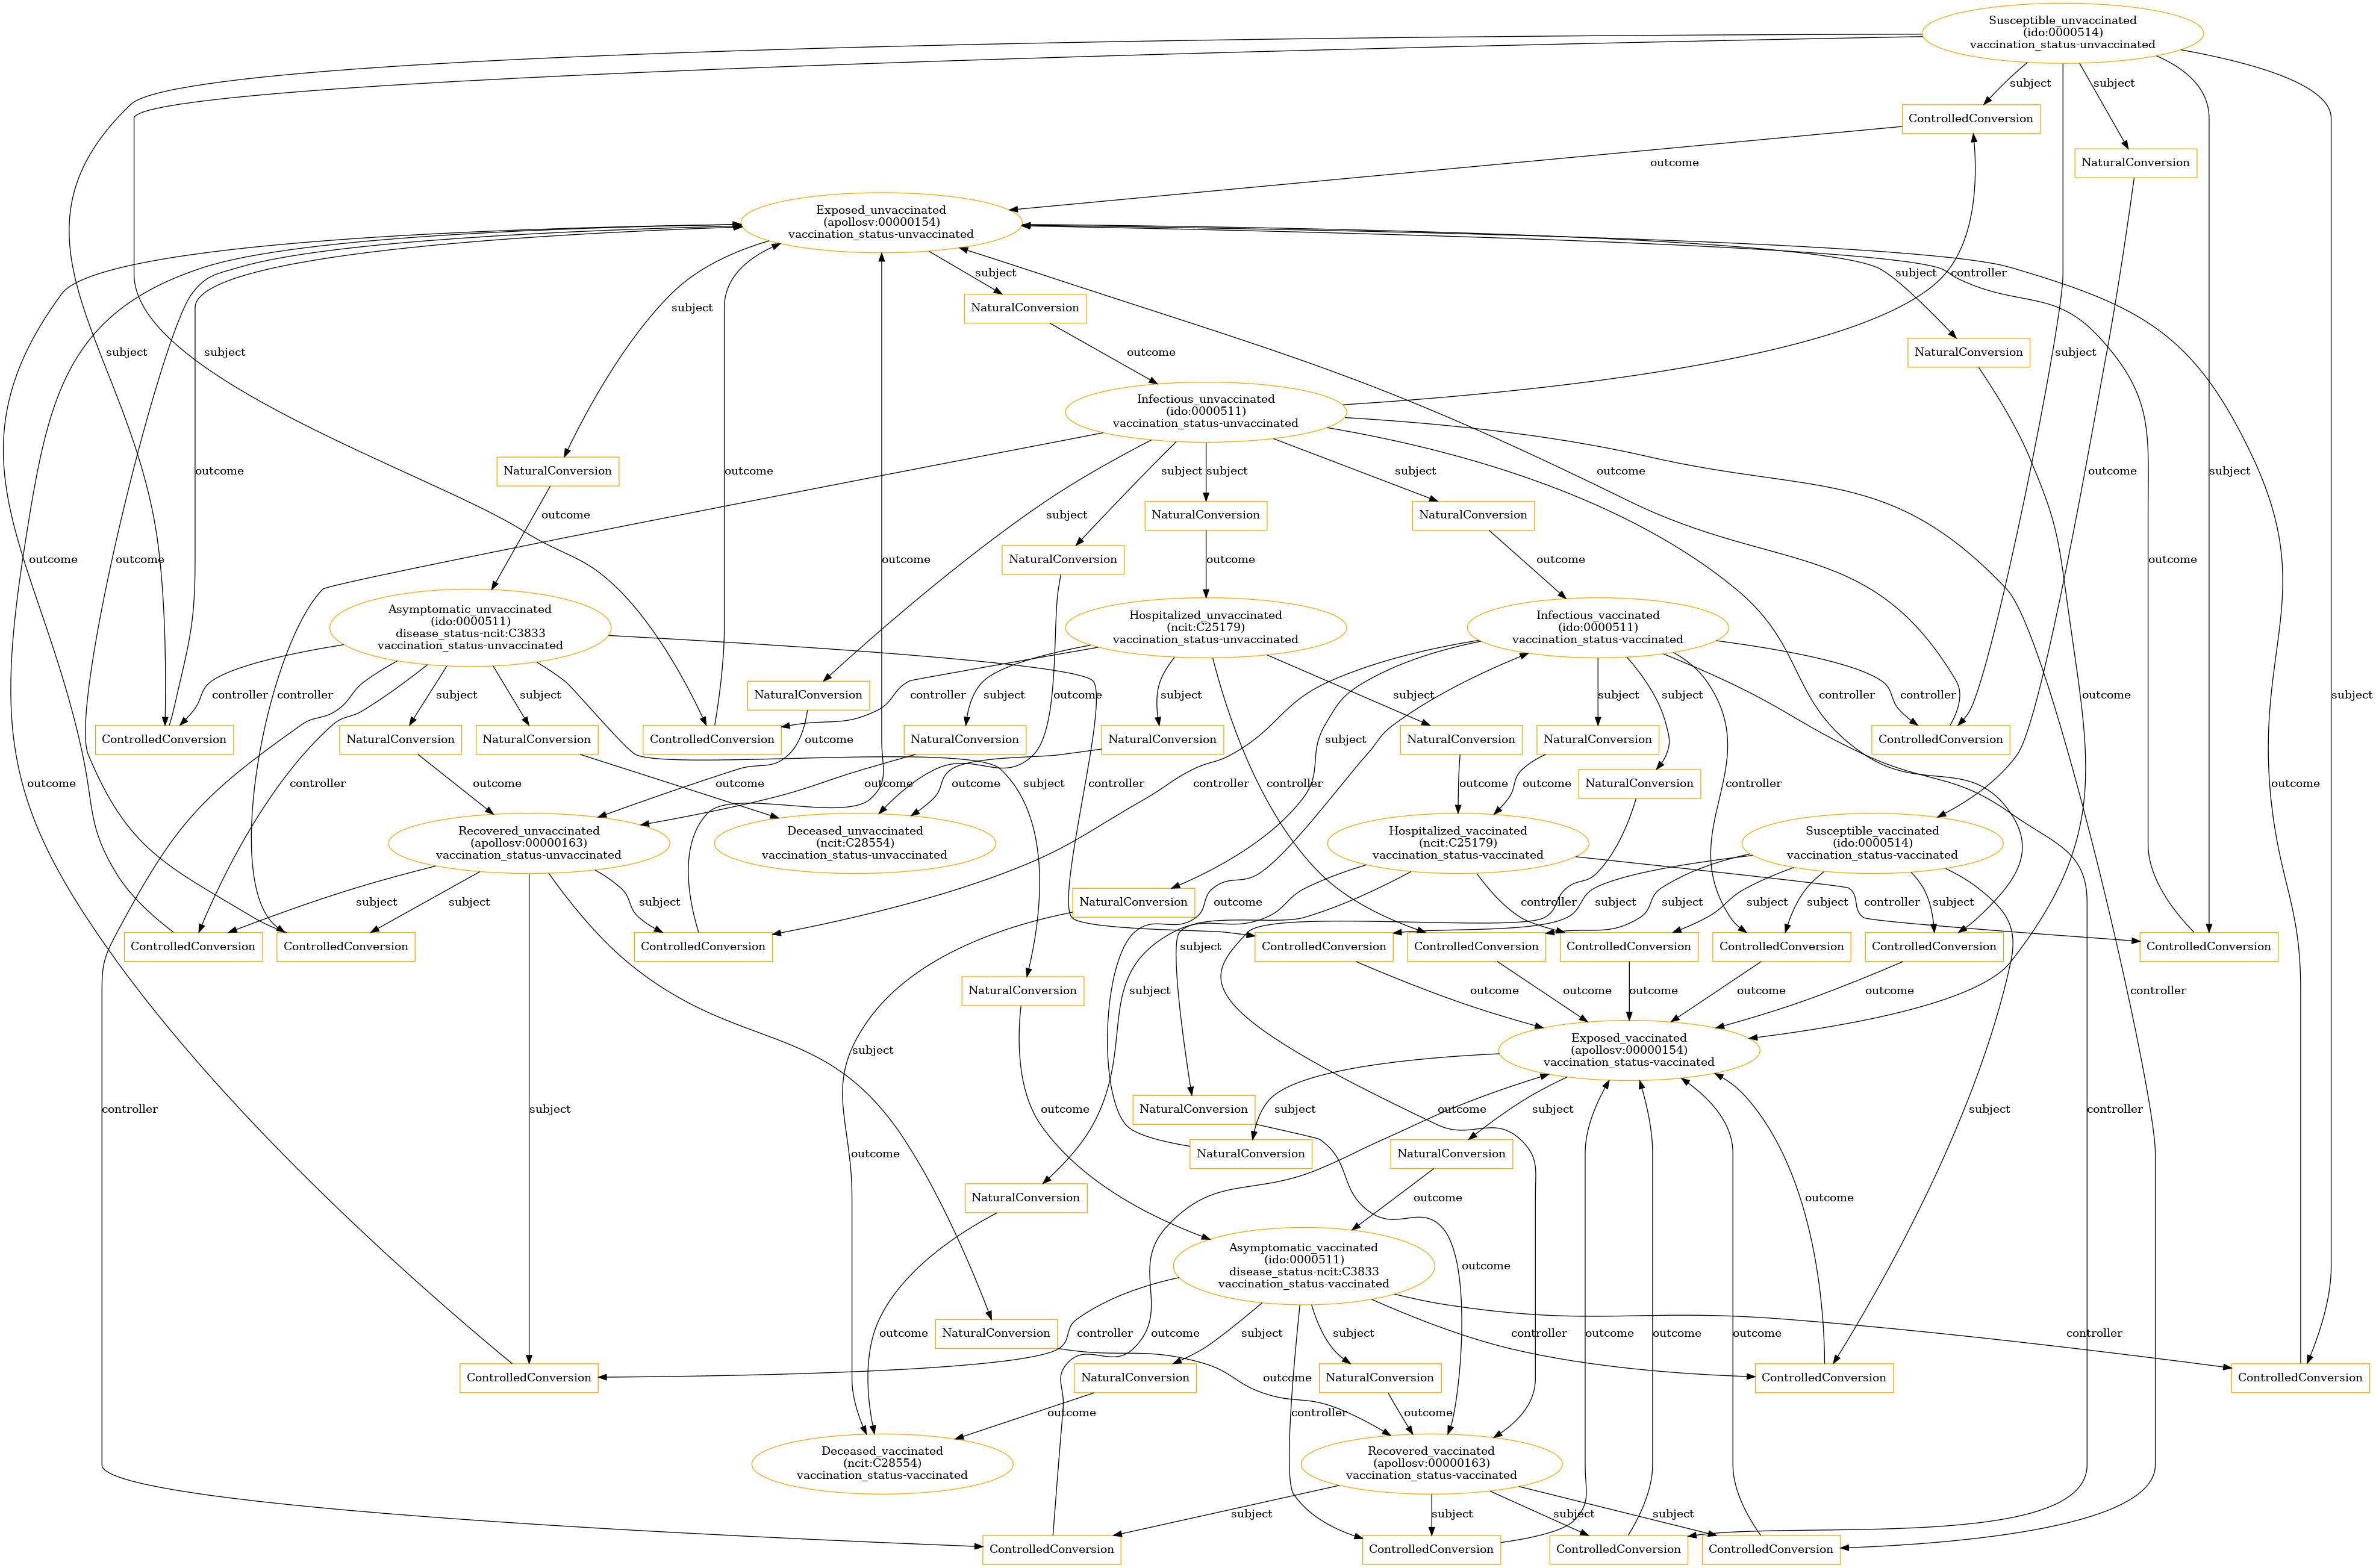

In [14]:
# Stratify model 960
model_960_vaccination_reinfection = stratify(
    model_960_reinfection,
    key="vaccination_status",
    strata=["unvaccinated", "vaccinated"],
    directed=True,
    cartesian_control=True,
    modify_names=True
)

# Prune vaccination transitions: Deceased unvaccinated -> Deceased vaccinated
model_ix = None
death_vaccination_transition = None
for ix, template in enumerate(model_960_vaccination_reinfection.templates):
    if isinstance(template, NaturalConversion):
        if template.subject.name == "Deceased_unvaccinated" and template.outcome.name == "Deceased_vaccinated":
            model_ix = ix
            death_vaccination_transition = template
            break

assert model_ix is not None
assert death_vaccination_transition is not None
# Remove the template
model_960_vaccination_reinfection.templates.pop(model_ix)

model_960_vaccination_reinfection.draw_graph("scenario3_model_960_vaccination_reinfection.png")
Image(filename="scenario3_model_960_vaccination_reinfection.png")

In [15]:
# Now compare the models again
tm_reinfection = TemplateModelDelta(template_model1=model_958_vaccination_reinfection,
                                    template_model2=model_960_vaccination_reinfection,
                                    refinement_function=is_ontological_child_web)
tm_reinfection.draw_graph("scenario3_model_958_960_delta_reinfection.png")
Image("scenario3_model_958_960_delta_reinfection.png")  # Image is 7+ MB and may have issues rendering for jupyter or your IDE

ConnectionError: ('Connection aborted.', TimeoutError(110, 'Connection timed out'))